- abstract type: soil, pools, elements
- abstract type: parameters, soil and plant, 

In [1]:
## note1: qom_dom was put in flux!(DOM) and struct DOM 
using Plots
using UnPack
using DataFrames

In [2]:
Base.@kwdef mutable struct SoilPar
    "parameters"
    fRa::Float64 = 0.2
    fINP::Float64 = 0.3
    vd_pomo::Float64   = 50.0
    vd_pomh::Float64   = 50.0
    vd_mom::Float64    = vd_pomh * 0.01
    ks_pomo::Float64   = 60.0
    fKM::Float64       = 10.0
    ks_pomh::Float64   = ks_pomo/fKM
    ks_mom::Float64    = ks_pomo * fKM
    Qmax::Float64      = 1.5
    Kba::Float64       = 6.0 
    Kdes::Float64      = 0.006 
    Kads::Float64      = Kdes * Kba    
    Kp2u::Float64      = 0.000005
    Ku2p::Float64      = 0.001
    rENZM::Float64     = 0.00012289
    rENZPo::Float64    = rENZM
    rENZPh::Float64    = rENZM
    pENZP::Float64     = 0.00147568
    fpEM::Float64      = 4.50361918
    pENZM::Float64     = pENZP * fpEM    
    frPOM2DOM::Float64 = 0.75
    frMB2DOM::Float64  = 0.5
    frMBA_to_POMo::Float64 = 0.1
    frMBA_to_POMh::Float64 = 0.9
    Vg::Float64        = 0.00425194
    alpha::Float64     = 0.05012233
    Vm::Float64        = Vg * alpha/(1.0 - alpha)
    KsDOM::Float64     = 0.00010034
    Yg::Float64        = 0.20109320 
    Ygsl::Float64      = 0.00520677
    CUE_slope::Float64 = -1.0*Ygsl
    Q10::Float64       = 1.8
    gamma::Float64     = 0.01030726
    rMORT::Float64     = min(0.99,Vm * gamma)
    beta::Float64      = 0.001
    VmD::Float64       = Vm * beta
    VmA2D::Float64     = Vm #* tp_scalar * wp_scalar_low
    VmD2A::Float64     = Vm #* tp_scalar * wp_scalar
    SWP_A2D::Float64   = 0.46
    tau::Float64       = 0.39
    SWP_D2A::Float64   = tau * SWP_A2D
    wdorm::Float64     = 3.38
    VNup_MB::Float64   = 0.1
    VNup_VG::Float64   = 0.00003296
    rNleach::Float64   = 0.02
    bNup_VG::Float64   = 0.5
    KsNH4_MB::Float64  = 0.00018
    KsNO3_MB::Float64  = 0.00041
    # YgN = sPAR%YgN        = phi 
    Qmax_NH4::Float64  = 0.0057442
    Kba_NH4::Float64   = 100.0
    KsNH4_VG::Float64  = 0.0012
    KsNO3_VG::Float64  = 0.0018
    fpENZN::Float64    = 1.0
    VNif::Float64      = 0.0635041
    VNit::Float64      = 185.28188371
    VDenit::Vector{Float64} = [0.86952628,0.86952628,0.86952628,0.86952628]
    # VDenit(1) = 0.86952628
    # VDenit(2) = 0.86952628
    # VDenit(3) = 0.86952628
    # VDenit(4) = 0.86952628
    KsNif::Float64 = 0.1
    KsNit::Float64 = 0.0012
    KsDenit::Vector{Float64} = [0.0018,0.0018,0.0018,0.0018]
    # KsDenit(1) = 0.0018
    # KsDenit(2) = 0.0018
    # KsDenit(3) = 0.0018
    # KsDenit(4) = 0.0018 
    
end

SoilPar

In [3]:
mutable struct Elements{FT<:AbstractFloat}
    c::FT
    n::FT
    p::FT 
end

struct Pools
    POMo::Elements
    POMh::Elements
    MOM ::Elements
    DOM ::Elements
    QOM ::Elements
    MBA ::Elements 
    MBD ::Elements
    EPO ::Elements 
    EPH ::Elements 
    EM  ::Elements 
end

mutable struct CPools{FT<:AbstractFloat}
    POMo::FT
    POMh::FT
    MOM ::FT
    DOM ::FT
    QOM ::FT
    MBA ::FT 
    MBD ::FT
    EPO ::FT 
    EPH ::FT 
    EM  ::FT 
end

mutable struct NPools{FT<:AbstractFloat}
    POMo::FT
    POMh::FT
    MOM ::FT
    DOM ::FT
    QOM ::FT
    MBA ::FT 
    MBD ::FT
    EPO ::FT 
    EPH ::FT 
    EM  ::FT 
end

mutable struct PPools{FT<:AbstractFloat}
    POMo::FT
    POMh::FT
    MOM ::FT
    DOM ::FT
    QOM ::FT
    MBA ::FT 
    MBD ::FT
    EPO ::FT 
    EPH ::FT 
    EM  ::FT 
end

mutable struct CNPools{FT<:AbstractFloat}
    POMo::FT
    POMh::FT
    MOM ::FT
    DOM ::FT
    QOM ::FT
    MBA ::FT 
    MBD ::FT
    EPO ::FT 
    EPH ::FT 
    EM  ::FT 
end

In [4]:
## adding layers 
Base.@kwdef struct SoilLayersX{FT<:AbstractFloat}
    layer1::Array{FT,1} = [0.0,10.0] # in centimeter
    layer2::Array{FT,1} = [10.0,30.0]
    layer3::Array{FT,1} = [30.0,50.0]
    layer4::Array{FT,1} = [50.0,70.0]
    layer5::Array{FT,1} = [70.0,100.0]
end

In [5]:
Base.@kwdef mutable struct Flux_POMo
    pomo_dom::Float64 = 0.0
    pomo_mom::Float64 = 0.0
end

Base.@kwdef mutable struct Flux_POMh
    pomh_dom::Float64 = 0.0
    pomh_mom::Float64 = 0.0
end

Base.@kwdef mutable struct Flux_MOM 
    mom_dom::Float64 = 0.0
end

Base.@kwdef mutable struct Flux_DOM 
    dom_mba::Float64 = 0.0
    dom_qom::Float64 = 0.0
    qom_dom::Float64 = 0.0
end


Base.@kwdef mutable struct Flux_MBA 
    co2_maintn::Float64 = 0.0
    co2_growth::Float64 = 0.0
    mba_pomh::Float64 = 0.0
    mba_pomo::Float64 = 0.0
    mba_dom::Float64 = 0.0
    mba_mbd::Float64 = 0.0
    mba_eph::Float64 = 0.0
    mba_epo::Float64 = 0.0
    mba_em::Float64 = 0.0
end

Base.@kwdef mutable struct Flux_MBD
    mbd_mba::Float64 = 0.0
    co2_maintn::Float64 = 0.0
end


Flux_MBD

In [6]:
##1 all Michaelis-Menten equations

function MM(par::SoilPar,pools::CPools,flux::Flux_POMo) 
    @unpack vd_pomo, ks_pomo  = par
    @unpack POMo, EPO = pools
    vm = vd_pomo   
    km = ks_pomo
    substrate = POMo
    enzyme = EPO 
        
    MM = vm * substrate * enzyme/(km + substrate)
    MM = min(MM, substrate)
    return MM
end

function MM(par::SoilPar,pools::CPools,flux::Flux_POMh) 
    @unpack vd_pomh, ks_pomh  = par
    @unpack POMh, EPH = pools
    vm = vd_pomh   
    km = ks_pomh
    substrate = POMh
    enzyme = EPH 
        
    MM = vm * substrate * enzyme/(km + substrate)
    MM = min(MM, substrate)
    return MM
end

function MM(par::SoilPar,pools::CPools,flux::Flux_MOM) 
    @unpack vd_mom, ks_mom  = par
    @unpack MOM, EM = pools
    vm = vd_mom   
    km = ks_mom
    substrate = MOM
    enzyme = EM 
        
    MM = vm * substrate * enzyme/(km + substrate)
    MM = min(MM, substrate)
    return MM
end

function MM(par::SoilPar,pools::CPools,flux::Flux_DOM) 
    @unpack Vg, Vm, Yg, KsDOM  = par
    @unpack DOM, MBA = pools
    vm = (Vg + Vm)/Yg    
    km = KsDOM
    substrate = DOM
    enzyme = MBA
        
    MM = vm * substrate * enzyme/(km + substrate)
    MM = min(MM, substrate)
    return MM
end

function MM(par::SoilPar,pools::CPools,flux::Flux_MBA) 
    @unpack Vg, Yg, KsDOM, Vm  = par
    @unpack MBA,DOM = pools
    enzyme    = MBA 
    substrate = DOM
    vm = Vg * (1.0/Yg - 1.0)   
    km = KsDOM
        
    MM_growth = vm * substrate * enzyme/(km + substrate)
    MM_growth = min(MM_growth, substrate)

    vm = Vm * (1.0/Yg - 1.0)
    MM_maintn = vm * substrate * enzyme/(km + substrate)
    MM_maintn = min(MM_maintn, substrate)
    return MM_growth, MM_maintn
end


MM (generic function with 5 methods)

In [7]:
##2 develop functions: Fluxes

function Flux!(par::SoilPar,pools::CPools,flux::Flux_POMo)
    @unpack frPOM2DOM = par
    pomo_dec = MM(par,pools,flux)
    pomo_dom = frPOM2DOM * pomo_dec
    pomo_mom = (1.0 - frPOM2DOM) * pomo_dec  

    flux.pomo_dom = pomo_dom
    flux.pomo_mom = pomo_mom 
    return pomo_dom,pomo_mom  
end

function Flux!(par::SoilPar,pools::CPools,flux::Flux_POMh)
    @unpack frPOM2DOM = par
    pomh_dec = MM(par,pools,flux)
    pomh_dom = frPOM2DOM * pomh_dec
    pomh_mom = (1.0 - frPOM2DOM) * pomh_dec 

    flux.pomh_dom = pomh_dom
    flux.pomh_mom = pomh_mom 
    return pomh_dom,pomh_mom  
end

function Flux!(par::SoilPar,pools::CPools,flux::Flux_MOM)
    mom_dec      = MM(par,pools,flux)
    mom_dom      = mom_dec

    flux.mom_dom = mom_dom
    return mom_dom 
end

function Flux!(par::SoilPar,pools::CPools,flux::Flux_DOM)
    @unpack DOM,QOM = pools 
    @unpack Kads,Qmax,Kdes = par
    dom_dec = MM(par,pools,flux)
    dom_mba = dom_dec 
    
    # ========================
    # ads,des = AdsDesorption(par,pools) 
    _DOM = DOM - dom_mba # the preference given to microbial uptake then ad_de
    adsorbate = _DOM
    adsorbent = QOM
    ads = Kads * adsorbate * (1.0 - adsorbent/Qmax)
    des = Kdes * adsorbent / Qmax
    if des > (adsorbent + ads)
        des = adsorbent + ads 
    elseif ads > adsorbate + des 
        ads = adsorbate + des
    end 
    # ========================
    dom_qom = ads  
    qom_dom = des

    flux.dom_mba = dom_mba
    flux.dom_qom = dom_qom
    flux.qom_dom = qom_dom
    return dom_mba, dom_qom, qom_dom 
end

function Flux!(par::SoilPar,pools::CPools,flux::Flux_MBA)
    @unpack rMORT, frMB2DOM, frMBA_to_POMh, frMBA_to_POMo, KsDOM, VmA2D = par
    @unpack MBA,DOM = pools 
    mb = MBA
    mba_mortality= rMORT * mb
    mba_dom   = frMB2DOM * mba_mortality
    mba_pomh   = (1.0 - frMB2DOM) * mba_mortality * frMBA_to_POMh
    mba_pomo   = (1.0 - frMB2DOM) * mba_mortality * frMBA_to_POMo
    
    phi = DOM/(DOM + KsDOM)
    mba_mbd = (1.0 - phi) * VmA2D * mb
    mba_CO2_growth, mba_CO2_maintn = MM(par,pools,flux) # Respiration of MBA

    flux.mba_dom        = mba_dom
    flux.mba_pomo       = mba_pomo
    flux.mba_pomh       = mba_pomh
    flux.mba_mbd        = mba_mbd
    flux.co2_growth = mba_CO2_growth
    flux.co2_maintn = mba_CO2_maintn
    return mba_mortality,mba_dom,mba_pomo,mba_pomh,mba_mbd,mba_CO2_growth,mba_CO2_maintn
end

function Flux!(par::SoilPar,pools::CPools,flux::Flux_MBD) # Respiration of MBD and resurcitaion
    @unpack KsDOM,VmD2A,VmD = par
    @unpack DOM,MBD = pools
    phi = DOM/(DOM + KsDOM)
    mbd_mba = phi * VmD2A * MBD
    mbd_CO2_maintn = VmD * MBD 

    flux.mbd_mba        = mbd_mba
    flux.co2_maintn = mbd_CO2_maintn
    return mbd_mba, mbd_CO2_maintn
end




Flux! (generic function with 6 methods)

In [8]:
## 3 developing functions: enzymes

function EnzymeProduction(par::SoilPar,pools::CPools)
    @unpack pENZP, Vm, pENZM = par
    @unpack MBA,POMo,POMh = pools 
    
    frPOMh = POMh/(POMh + POMo)
    mba_enzph = frPOMh * pENZP * Vm * MBA
    mba_enzpo = (1-frPOMh) * pENZP * Vm * MBA
    mba_enzm =  pENZM * Vm * MBA
    return mba_enzph, mba_enzpo, mba_enzm 
end 

function EnzymeTurnover(par::SoilPar,pools::CPools)
    epo_dom = par.rENZPo * pools.EPO
    eph_dom = par.rENZPh * pools.EPH
    em_dom  = par.rENZM * pools.EM
    return epo_dom,eph_dom,em_dom
end


EnzymeTurnover (generic function with 1 method)

In [9]:
##4 developing functions: carbon pools 
function CPools!(par::SoilPar,pools::CPools,input_c)
    @unpack POMo,POMh,MOM,DOM,QOM,MBA,MBD,EPO,EPH,EM = pools
    # @unpack EPO,EPH,EM = pools
    litter_pomo = input_c.litter_pomo_array
    litter_pomh = input_c.litter_pomh_array
    litter_dom = input_c.litter_dom_array

    pomo_dec = MM(par,pools,flux_pomo); pomh_dec = MM(par,pools,flux_pomh);
    mom_dec = MM(par,pools,flux_mom); dom_dec = MM(par,pools,flux_dom);

    pomo_dom,pomo_mom = Flux!(par,pools,flux_pomo)
    pomh_dom,pomh_mom = Flux!(par,pools,flux_pomh)
    dom_mba, dom_qom, qom_dom = Flux!(par,pools,flux_dom)
    
    mba_mortality, mba_dom, mba_pomo, mba_pomh,
    mba_mbd, mba_CO2_growth, mba_CO2_maintn = 
    Flux!(par,pools,flux_mba);

    mbd_mba, mbd_CO2_maintn = Flux!(par,pools,flux_mbd)

    epo_dom,eph_dom,em_dom = EnzymeTurnover(par,pools)

    mba_eph, mba_epo, mba_em = EnzymeProduction(par,pools)

    pools.POMo = POMo - pomo_dec + mba_pomo + litter_pomo
    pools.POMh = POMh - pomh_dec + mba_pomh + litter_pomh
    pools.MOM = MOM - mom_dec + pomo_mom + pomh_mom 
    pools.DOM = (DOM - dom_dec - dom_qom + qom_dom + litter_dom + pomh_dom 
                + pomo_dom + mba_dom + epo_dom + eph_dom + em_dom)
    pools.QOM = QOM - qom_dom + dom_qom

    pools.MBA = (MBA - mba_mortality - mba_mbd - mba_CO2_growth 
                - mba_CO2_maintn + dom_mba + mbd_mba
                - mba_eph - mba_epo - mba_em)

    pools.MBD = MBD - mbd_mba - mbd_CO2_maintn + mba_mbd

    pools.EPO = EPO + mba_epo - epo_dom
    pools.EPH = EPH + mba_eph - eph_dom
    pools.EM = EM + mba_em - em_dom
    
    return nothing 
end

CPools! (generic function with 1 method)

In [29]:
## emply struct for multiple dispatch
struct par_dec end 
struct par_con end
struct par_inc end 

struct daily_output end
struct depth_output end

In [11]:
function VaryTraitsDepth!(par::SoilPar,sl::SoilLayersX,ilayer::Integer,::Type{par_dec})
    @unpack vd_pomh,vd_pomo,vd_mom = par 
    @unpack Yg, Vg, Vm, Q10 = par
    @unpack layer1,layer2,layer3,layer4,layer5 = sl
    nlayers = 5
    if ilayer==1
        par.vd_pomh = vd_pomh * (100.0-layer1[1])/100.0  # assume a linear decrease with depth  
        par.vd_pomo = par.vd_pomh
        par.vd_mom = 0.01 * par.vd_pomh

        par.Yg = Yg * (100.0-layer1[1])/100.0
    elseif ilayer==2
        par.vd_pomh = vd_pomh * (100.0-layer2[1])/100.0
        par.vd_pomo = par.vd_pomh
        par.vd_mom = 0.01 * par.vd_pomh

        par.Yg = Yg * (100.0-layer2[1])/100.0
    elseif ilayer==3
        par.vd_pomh = vd_pomh * (100.0-layer3[1])/100.0
        par.vd_pomo = par.vd_pomh
        par.vd_mom = 0.01 * par.vd_pomh

        par.Yg = Yg * (100.0-layer3[1])/100.0
    elseif ilayer==4
        par.vd_pomh = vd_pomh * (100.0-layer4[1])/100.0
        par.vd_pomo = par.vd_pomh
        par.vd_mom = 0.01 * par.vd_pomh

        par.Yg = Yg * (100.0-layer4[1])/100.0
    elseif ilayer==5
        par.vd_pomh = vd_pomh * (100.0-layer5[1])/100.0
        par.vd_pomo = par.vd_pomh
        par.vd_mom = 0.01 * par.vd_pomh

        par.Yg = Yg * (100.0-layer5[1])/100.0
    else
        par.vd_pomh = vd_pomh
        par.vd_pomo = vd_pomo
        par.vd_mom  = vd_mom
        par.Yg      = Yg
    end
    return nothing
end

function VaryTraitsDepth!(par::SoilPar,sl::SoilLayersX,ilayer::Integer,::Type{par_con})
    @unpack vd_pomh,vd_pomo,vd_mom = par 
    @unpack Yg, Vg, Vm, Q10 = par
    @unpack layer1,layer2,layer3,layer4,layer5 = sl
    nlayers = 5
    par.vd_pomh = vd_pomh
    par.vd_pomo = vd_pomo
    par.vd_mom  = vd_mom
    par.Yg      = Yg
    
    return nothing
end

function VaryTraitsDepth!(par::SoilPar,sl::SoilLayersX,ilayer::Integer,::Type{par_inc})
    @unpack vd_pomh,vd_pomo,vd_mom = par 
    @unpack Yg, Vg, Vm, Q10 = par
    @unpack layer1,layer2,layer3,layer4,layer5 = sl
    nlayers = 5
    if ilayer==1
        par.vd_pomh = vd_pomh * (100.0+layer1[1])/100.0  # assume a linear decrease with depth  
        par.vd_pomo = par.vd_pomh
        par.vd_mom = 0.01 * par.vd_pomh

        par.Yg = Yg * (100.0+layer1[1])/100.0
    elseif ilayer==2
        par.vd_pomh = vd_pomh * (100.0+layer2[1])/100.0
        par.vd_pomo = par.vd_pomh
        par.vd_mom = 0.01 * par.vd_pomh

        par.Yg = Yg * (100.0+layer2[1])/100.0
    elseif ilayer==3
        par.vd_pomh = vd_pomh * (100.0+layer3[1])/100.0
        par.vd_pomo = par.vd_pomh
        par.vd_mom = 0.01 * par.vd_pomh

        par.Yg = Yg * (100.0+layer3[1])/100.0
    elseif ilayer==4
        par.vd_pomh = vd_pomh * (100.0+layer4[1])/100.0
        par.vd_pomo = par.vd_pomh
        par.vd_mom = 0.01 * par.vd_pomh

        par.Yg = Yg * (100.0+layer4[1])/100.0
    elseif ilayer==5
        par.vd_pomh = vd_pomh * (100.0+layer5[1])/100.0
        par.vd_pomo = par.vd_pomh
        par.vd_mom = 0.01 * par.vd_pomh

        par.Yg = Yg * (100.0+layer5[1])/100.0
    else
        par.vd_pomh = vd_pomh
        par.vd_pomo = vd_pomo
        par.vd_mom  = vd_mom
        par.Yg      = Yg
    end
    return nothing
end

VaryTraitsDepth! (generic function with 3 methods)

In [12]:
# temperature dependence 
function fTQ10(T, Q10, Tref=20.0)
    fTQ10 = Q10^((T-Tref)/10.0)
end


fTQ10 (generic function with 2 methods)

In [13]:
##5 Initialize the model
"""
parameters altered with depth
"""

# parameterization
function InitParDepth!(par::SoilPar,ilayer,par_vary)
    sl = SoilLayersX()
    # par_vary = par_dec
    VaryTraitsDepth!(par,sl,ilayer,par_vary)
    # VaryTraitsClima!(par,sl,ilayer)
    return nothing
end

function InitCPools(ilayer)
    # initial carbon pool
    sl = SoilLayersX()
    sl_dif = [(sl.layer1[2]-sl.layer1[1]),
                (sl.layer2[2]-sl.layer2[1]),
                (sl.layer3[2]-sl.layer3[1]),
                (sl.layer4[2]-sl.layer4[1]),
                (sl.layer5[2]-sl.layer5[1]),
                100.0]

    allocationcoeff = [0.35,0.3,0.2,0.1,0.05,1.0]
    scalar = 100.0/sl_dif[ilayer]
    soc = 1.578 * allocationcoeff[ilayer] * scalar # mg/cm3 
    poc = 0.377 * allocationcoeff[ilayer] * scalar
    poc_o = poc * LF0; poc_h = poc * (1.0 - LF0); 

    moc = 1.064 * allocationcoeff[ilayer] * scalar ;
    qoc = moc * fQOM; 

    doc = 0.137 * allocationcoeff[ilayer] * scalar;

    mbc = 0.033 * allocationcoeff[ilayer] * scalar; 
    mbc_a = mbc * r0; mbc_d = mbc * (1.0 - r0);

    epo = 6.0e-5 * allocationcoeff[ilayer] * scalar
    eph = 6.0e-5 * allocationcoeff[ilayer] * scalar
    em  = 6.0e-5 * allocationcoeff[ilayer] * scalar

    # _CPools = CPools(10000.,10000.,2000.,200.,120.,100.,150.,0.1,0.1,0.1)
    cpools = CPools(poc_o,poc_h,moc,doc,qoc,mbc_a,mbc_d,epo,eph,em)
    return cpools
end

function InitCInputs(ilayer,par)
    ## carbon input
    # litter_pomo = 100000.0/365.0/24.0 * 0.5
    # litter_pomh = 100000.0/365.0/24.0 * 0.25
    # litter_dom = 100000.0/365.0/24.0 * 0.25
    allocationcoeff = [0.35,0.3,0.2,0.1,0.05,1.0]

    SIN_day_str = readlines("./SIN_day.dat") # unit: mgC-cm2-d

    SIN_day = parse.(Float64, SIN_day_str) # string to numeric

    SIN_day = SIN_day[3:end]

    SIN_hour = SIN_day ./24

    SIN_input = SIN_hour .* par.fINP;
    
    sl = SoilLayersX()
    sl_dif = [(sl.layer1[2]-sl.layer1[1]),
                (sl.layer2[2]-sl.layer2[1]),
                (sl.layer3[2]-sl.layer3[1]),
                (sl.layer4[2]-sl.layer4[1]),
                (sl.layer5[2]-sl.layer5[1]),
                100.0]

    # 0.07, 0.37, 0.56 # fraction type I
    f_l_pomo = 0.07 # to be added to parameter list 
    f_l_pomh = 0.37 # to be added to parameter list
    f_l_dom = 0.56 # to be added to parameter list
    litter_pomo_array = SIN_input .* f_l_pomo/sl_dif[ilayer] * allocationcoeff[ilayer];
    litter_pomh_array = SIN_input .* f_l_pomh/sl_dif[ilayer] * allocationcoeff[ilayer];
    litter_dom_array  = SIN_input .* f_l_dom/sl_dif[ilayer] * allocationcoeff[ilayer]; 
    input_c = DataFrame()
    input_c[!,"litter_pomo_array"] = litter_pomo_array
    input_c[!,"litter_pomh_array"] = litter_pomh_array
    input_c[!,"litter_dom_array"]  = litter_dom_array
    return input_c
end


InitCInputs (generic function with 1 method)

In [14]:
## create dataframe to store output 

function create_dataframe(FT,ncycle,nyear)#(FT,weather::DataFrame)
    
    df    = DataFrame();
   
    df[!, "Time"  ] = zeros(ncycle*nyear*365);
    df[!, "POMh" ] .= FT(0);
    df[!, "POMo" ] .= FT(0);
    df[!, "MOM"  ] .= FT(0);
    df[!, "DOM"  ] .= FT(0);
    df[!, "QOM"    ] .= FT(0);

    
    df[!, "MBA"   ] .= FT(0);
    df[!, "MBD"] .= FT(0);

    return df
end

function create_dataframe(FT,nlayer)#(FT,weather::DataFrame)
    
    df    = DataFrame();
   
    df[!, "Layer"  ] = zeros(nlayer+1);
    df[!, "POMh" ] .= FT(0);
    df[!, "POMo" ] .= FT(0);
    df[!, "MOM"  ] .= FT(0);
    df[!, "DOM"  ] .= FT(0);
    df[!, "QOM"  ] .= FT(0);

    
    df[!, "MBA"] .= FT(0);
    df[!, "MBD"] .= FT(0);

    return df
end

create_dataframe (generic function with 2 methods)

In [30]:
##7: model run with depth

function ModRunDepth!(par::SoilPar,cpools::CPools,ilayer::Integer,
                      output_ly::DataFrame,input_c::DataFrame,::Type{depth_output})
# function ModRunDepth!(par::SoilPar,cpools::CPools,ilayer::Integer)

    for icycle = 1:ncycle
        for iday = 1:365*nyear
            for ihour = 1:24
                input_c_time = input_c[iday,:]
                CPools!(par,cpools,input_c_time)  
            end
        end 
    end
    output_ly[ilayer,"Layer"] = ilayer
    output_ly[ilayer,"POMh"] = cpools.POMh
    output_ly[ilayer,"POMo"] = cpools.POMo
    output_ly[ilayer,"MOM"] = cpools.MOM
    output_ly[ilayer,"DOM"] = cpools.DOM
    output_ly[ilayer,"QOM"] = cpools.QOM
    output_ly[ilayer,"MBA"] = cpools.MBA
    output_ly[ilayer,"MBD"] = cpools.MBD
end 

function ModRunDepth!(par::SoilPar,cpools::CPools,ilayer::Integer,output_ly::DataFrame,
                      input_c::DataFrame,::Type{daily_output})
# function ModRunDepth!(par::SoilPar,cpools::CPools,ilayer::Integer)

    for icycle = 1:ncycle
        for iday = 1:365*nyear
            for ihour = 1:24
                # global litter_pomo = litter_pomo_array[iday]
                # global litter_pomh = litter_pomh_array[iday]
                # global litter_dom = litter_dom_array[iday]
                input_c_time = input_c[iday,:]
                CPools!(par,cpools,input_c_time)
            end
            output_ly[(icycle-1)*365*nyear+iday,"Time"] = (icycle-1)*365*nyear+iday
            output_ly[(icycle-1)*365*nyear+iday,"POMh"] = cpools.POMh
            output_ly[(icycle-1)*365*nyear+iday,"POMo"] = cpools.POMo
            output_ly[(icycle-1)*365*nyear+iday,"MOM"] = cpools.MOM
            output_ly[(icycle-1)*365*nyear+iday,"DOM"] = cpools.DOM
            output_ly[(icycle-1)*365*nyear+iday,"QOM"] = cpools.QOM
            output_ly[(icycle-1)*365*nyear+iday,"MBA"] = cpools.MBA
            output_ly[(icycle-1)*365*nyear+iday,"MBD"] = cpools.MBD
        end 
    end

end 




ModRunDepth! (generic function with 3 methods)

In [38]:
## default main program 
"""
only one layer
"""
nyear=10;ncycle=1;nlayer=5;
par_scenarios = ["con","dec","inc"]
# parameters to be added 
LF0 = 0.1
r0 = 0.01
fQOM = 0.05


# flux initilization (default values are 0s)
flux_pomo = Flux_POMo();flux_pomh = Flux_POMh();
flux_mom = Flux_MOM(); 
flux_dom = Flux_DOM(); # note: qom is wrapped in dom
flux_mba = Flux_MBA(); flux_mbd = Flux_MBD();

output_ly = create_dataframe(AbstractFloat,ncycle,nyear);
ilayer=6
par = SoilPar();
InitParDepth!(par,ilayer,par_con)
cpools = InitCPools(ilayer)
input_c = InitCInputs(ilayer,par);
ModRunDepth!(par,cpools,ilayer,output_ly,
            input_c,daily_output)

In [31]:
## main program
"""
note: there are in total 5 soil layers;
however, I add the 6th layer as a default for whole soil porfile
for comparison.
"""
nyear=10;ncycle=10;nlayer=5;
par_scenarios = ["con","dec","inc"]
# parameters to be added 
LF0 = 0.1
r0 = 0.01
fQOM = 0.05


# flux initilization (default values are 0s)
flux_pomo = Flux_POMo();flux_pomh = Flux_POMh();
flux_mom = Flux_MOM(); 
flux_dom = Flux_DOM(); # note: qom is wrapped in dom
flux_mba = Flux_MBA(); flux_mbd = Flux_MBD();

for par_scenario in par_scenarios
    @eval $(Symbol(:output_ly,"_",par_scenario)) = create_dataframe(AbstractFloat,nlayer);
    # output_ly = create_dataframe(AbstractFloat,nlayer);
    par_vary = @eval $(Symbol(:par,"_",par_scenario))
    output_ly = @eval $(Symbol(:output_ly,"_",par_scenario))
    

    for ilayer = 1:nlayer+1
        par = SoilPar();
        InitParDepth!(par,ilayer,par_vary)
        cpools = InitCPools(ilayer)
        input_c = InitCInputs(ilayer,par);
        ModRunDepth!(par,cpools,ilayer,output_ly,input_c,depth_output)
    end
end


In [32]:
## data processing

# df = Dict("output_ly_con" => output_ly_con,
#         "output_ly_dec" => output_ly_dec,
#         "output_ly_inc" => output_ly_inc)

# output_ly_scenarios = ["output_ly_con","output_ly_dec","output_ly_inc"]
# output_ly = df["output_ly_con"]

output_ly_con[:,"SOM"] = output_ly_con[:,"POMh"] + output_ly_con[:,"POMo"] + output_ly_con[:,"MOM"];
output_ly_dec[:,"SOM"] = output_ly_dec[:,"POMh"] + output_ly_dec[:,"POMo"] + output_ly_dec[:,"MOM"];
output_ly_inc[:,"SOM"] = output_ly_inc[:,"POMh"] + output_ly_inc[:,"POMo"] + output_ly_inc[:,"MOM"];




In [33]:
## convert concentration to content
sl = SoilLayersX();
sl_dif = [(sl.layer1[2]-sl.layer1[1]),
            (sl.layer2[2]-sl.layer2[1]),
            (sl.layer3[2]-sl.layer3[1]),
            (sl.layer4[2]-sl.layer4[1]),
            (sl.layer5[2]-sl.layer5[1]),
            100]
output_ly_con[:,"SOM_gm-2"] = output_ly_con[:,"SOM"] .* sl_dif * 100.0 * 100.0 * 10^(-3)
output_ly_dec[:,"SOM_gm-2"] = output_ly_dec[:,"SOM"] .* sl_dif * 100.0 * 100.0 * 10^(-3)
output_ly_inc[:,"SOM_gm-2"] = output_ly_inc[:,"SOM"] .* sl_dif * 100.0 * 100.0 * 10^(-3);

In [ ]:
sum(ll[2:end,:], dims=1)
# typeof(ll)
# 800/3680

In [34]:
## plotting
ll = Array{Float64}(undef, 5, 3)
for ilayer = 1:5
    # @eval $(Symbol(:l,ilayer)) = [output_ly_con[ilayer,"SOM"],
    #                               output_ly_dec[ilayer,"SOM"],
    #                               output_ly_inc[ilayer,"SOM"]]
    ll[ilayer,:]= [output_ly_con[ilayer,"SOM_gm-2"],
                    output_ly_dec[ilayer,"SOM_gm-2"],
                    output_ly_inc[ilayer,"SOM_gm-2"]]
end

using StatsPlots
label = ["0-10 cm" "10-30 cm" "30-50 cm" "50-70 cm" "70-100 cm"]
groupedbar(par_scenarios,transpose(ll),
            bar_position = :stack,
            bar_width=0.4,label=label,guidefontsize=8,
            legend=:outertopright,legendfontsize=10,
            foreground_color_legend = nothing,
            ylabel = "Soil Carbon (g/m2)",
            size=(400,200),dpi=600)

savefig("soc_CPools_layers_100yrs_now.png")

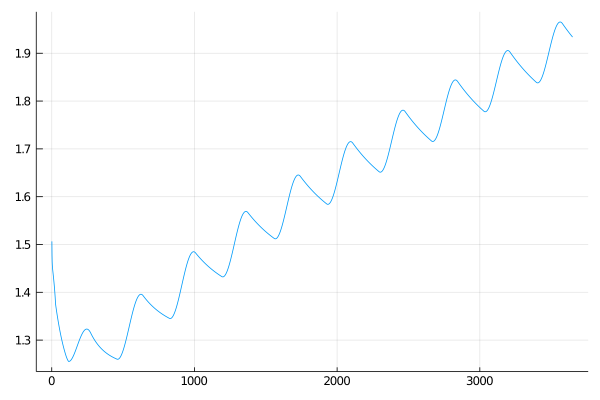

In [39]:
## plots
soc_total = output_ly.POMo + output_ly.POMh + output_ly.MOM + output_ly.DOM 
x=1:length(soc_total); y = soc_total[1:end] 
plot(x[1:end], y,label=false)
# savefig("test4_soc_CPools.png")